# Function 6: 5D Recipe optimization

*Analogy: **Combined score (flavour, consistency, calories, waste, cost); bad factors negative.**. We **maximize** \(y\) (e.g. throughput or reward vs baseline).*

### Characteristics

* **5D input**: \((x_1, x_2, x_3, x_4, x_5)\) — e.g. layout or routing parameters in \([0,1]^5\).

* **Objective**: Maximize \(y\). Initial data: initial points, shape (n, 5).

* **Strategy**: Same Bayesian optimisation workflow — GP surrogate, EI/PI/UCB acquisition — in 5D; visualisation uses 2D pairwise plots (no single 3D scatter).


## 1. Setup and load data (read-only from initial_data)


In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, Matern, WhiteKernel
from scipy.stats import norm
import warnings
warnings.filterwarnings("ignore")


# Project root: works whether you run from repo root or from notebooks/
repo_root = Path.cwd() if (Path.cwd() / "src").exists() else Path.cwd().parent
sys.path.insert(0, str(repo_root))

from src.utils.load_challenge_data import (
    load_function_data,
    load_problem_data_csv,
    save_problem_data_csv,
    assert_not_under_initial_data,
)
plt.style.use("seaborn-v0_8")


In [2]:
# --- Plot options; font/export defaults from utils (DEFAULT_*) ---
IF_SHOW_PLOT = True
IF_EXPORT_PLOT = True
PLOT_EXPORT_DIR = repo_root / "data" / "results"

IF_EXPORT_QUERIES = True
IF_APPEND_DATA = False

# Set seed for reproducibility
np.random.seed(42)


In [3]:
# ==== Candidate sampling (acquisition evaluation) ====
# Evaluated here — candidates are used by GP and acquisition functions in Section 3.
CANDIDATE_SAMPLING_METHOD = "random"   # "random" | "sobol" | "lhs"
n_cand = 2000                          # number of candidate points to evaluate acquisition on


In [4]:
# ==== Acquisition functions (inline — same as F1/F2/F3, no src dependency) ====
from scipy.stats import norm as _norm
import numpy as _np

def expected_improvement(mu, sigma, y_best, xi=0.01):
    mu, sigma = _np.asarray(mu), _np.asarray(sigma)
    imp = mu - y_best - xi
    Z = _np.where(sigma > 0, imp / sigma, 0.0)
    ei = _np.where(sigma > 0, imp * _norm.cdf(Z) + sigma * _norm.pdf(Z), 0.0)
    return ei

def upper_confidence_bound(mu, sigma, kappa=2.0):
    return _np.asarray(mu) + kappa * _np.asarray(sigma)

def probability_of_improvement(mu, sigma, y_best, xi=0.01):
    mu, sigma = _np.asarray(mu), _np.asarray(sigma)
    return _np.where(sigma > 0, _norm.cdf((mu - y_best - xi) / _np.where(sigma > 0, sigma, 1.0)), 0.0)

def thompson_sampling_sample(mu, sigma, rng=None):
    mu, sigma = _np.asarray(mu), _np.asarray(sigma)
    if rng is None:
        rng = _np.random.default_rng()
    return mu + sigma * rng.standard_normal(size=mu.shape)

def entropy_search(mu, sigma, y_best=None, xi=None):
    return -_np.asarray(sigma)

# ==== Plot utilities (inline constants + wrappers — no src dependency) ====
DEFAULT_FONT_SIZE_AXIS   = 9
DEFAULT_FONT_SIZE_TITLES = 10
DEFAULT_EXPORT_DPI       = 150
DEFAULT_EXPORT_FORMAT    = "png"

def style_axis(ax, *, xlabel=None, ylabel=None, title=None,
               font_size_axis=None, font_size_titles=None):
    fs = font_size_axis or DEFAULT_FONT_SIZE_AXIS
    ft = font_size_titles or DEFAULT_FONT_SIZE_TITLES
    if xlabel is not None: ax.set_xlabel(xlabel, fontsize=fs)
    if ylabel is not None: ax.set_ylabel(ylabel, fontsize=fs)
    if title  is not None: ax.set_title(title,  fontsize=ft)

def style_axis_3d(ax, *, xlabel=None, ylabel=None, zlabel=None, title=None,
                  font_size_axis=None, font_size_titles=None):
    fs = font_size_axis or DEFAULT_FONT_SIZE_AXIS
    ft = font_size_titles or DEFAULT_FONT_SIZE_TITLES
    if xlabel is not None: ax.set_xlabel(xlabel, fontsize=fs)
    if ylabel is not None: ax.set_ylabel(ylabel, fontsize=fs)
    if zlabel is not None: ax.set_zlabel(zlabel, fontsize=fs)
    if title  is not None: ax.set_title(title,  fontsize=ft)

def style_legend(ax, *, font_size_axis=None, **kw):
    return ax.legend(fontsize=font_size_axis or DEFAULT_FONT_SIZE_AXIS, **kw)

def add_colorbar(mappable, ax=None, *, label=None, font_size_axis=None, shrink=1.0, **kw):
    import matplotlib.pyplot as plt
    fs = font_size_axis or DEFAULT_FONT_SIZE_AXIS
    cb = plt.colorbar(mappable, ax=ax, shrink=shrink, **kw)
    if label is not None: cb.set_label(label, fontsize=fs)
    cb.ax.tick_params(labelsize=fs)
    return cb



In [5]:
# Load: under data/ we use only CSV. observations.csv if present, else initial_data (read-only).
local_dir = repo_root / "data" / "problems" / "function_6"
csv_path = local_dir / "observations.csv"
if csv_path.exists():
    X, y = load_problem_data_csv(csv_path)
    print("Loaded from local CSV (initial + appended):", csv_path)
else:
    X, y = load_function_data(function_id=6)
    print("Loaded from initial_data (read-only). Run append script or 'Append data' after portal feedback.")

print('Dataset info:')
print('Location of the dataset: ', local_dir)
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"X max value: {X.max():.6f}")
print(f"X min value: {X.min():.6f}")
print(f"y max value: {y.max():.6f}")
print(f"y min value: {y.min():.6f}")


Loaded from local CSV (initial + appended): /Users/nikolaskarefyllidis/Desktop/60_ML-AI/10 main optimization/10 ICL BBO Challenge/black-box-optimization/data/problems/function_6/observations.csv
Dataset info:
Location of the dataset:  /Users/nikolaskarefyllidis/Desktop/60_ML-AI/10 main optimization/10 ICL BBO Challenge/black-box-optimization/data/problems/function_6
X shape: (22, 5)
y shape: (22,)
X max value: 0.982521
X min value: 0.004911
y max value: -0.714265
y min value: -2.571170


### Progress

Left: y per query. Right: best y so far (cumulative max).


In [6]:
# Convergence: y per query (left) and running best (right)
n_obs = len(y)
best_y = np.maximum.accumulate(y)
print(f"Observations: {n_obs}, best y so far: {best_y[-1]:.4f}")


Observations: 22, best y so far: -0.7143


## 2. Visualize the points


In [7]:
# 5D Recipe optimization: visualise observations (2D pairwise only; no single 3D scatter for 5D)
# Candidate set for GP/acquisition (5D): random sample in [0,1]^4
candidate_pts = np.random.RandomState(42).uniform(0, 1, (n_cand, 5))
# Distance from each candidate to nearest observation (for baseline "high distance" suggestion)
diff = candidate_pts[:, None, :] - X[None, :, :]  # (n_cand, n_obs, 5)
dists = np.sqrt((diff ** 2).sum(axis=2))
min_dist = np.min(dists, axis=1)  # (n_cand,)


Plot saved to /Users/nikolaskarefyllidis/Desktop/60_ML-AI/10 main optimization/10 ICL BBO Challenge/black-box-optimization/data/results/function_6_observations_2d_pairs.png


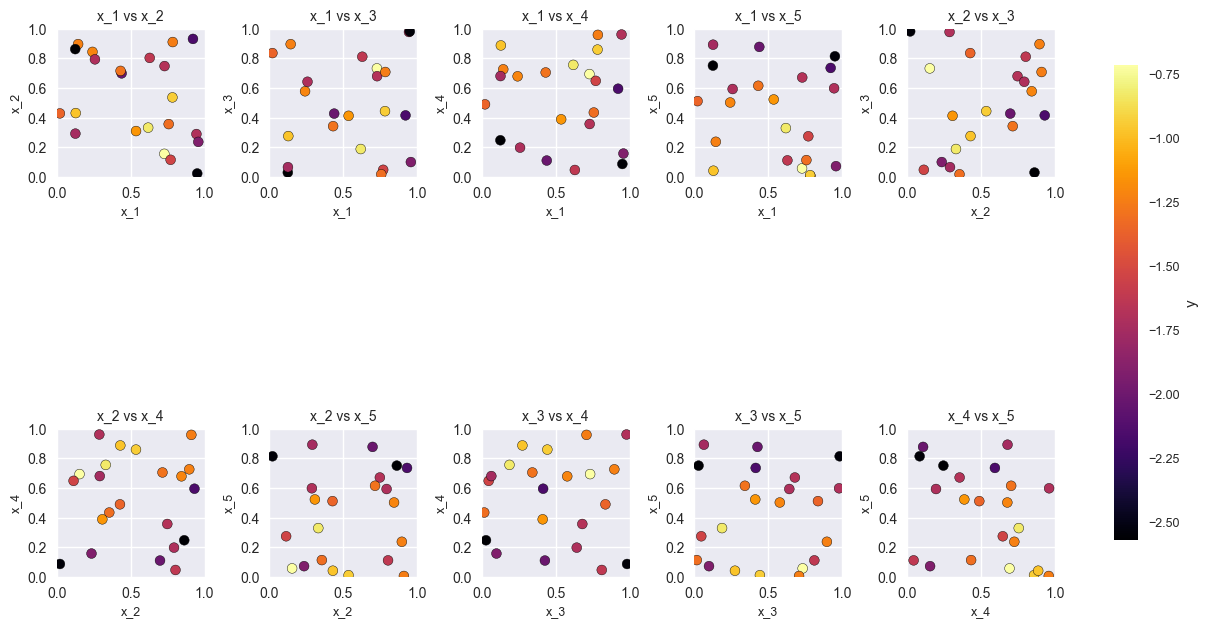

In [8]:
# 2D pairwise plots: all 10 pairs (x_1 vs x_2, x_1 vs x_3, x_1 vs x_4, x_2 vs x_3, x_2 vs x_4, x_3 vs x_4)
fig2, axes = plt.subplots(2, 5, figsize=(12, 8), constrained_layout=True)
axes = axes.ravel()
pairs = [(0, 1, "x_1", "x_2"), (0, 2, "x_1", "x_3"), (0, 3, "x_1", "x_4"), (0, 4, "x_1", "x_5"), (1, 2, "x_2", "x_3"), (1, 3, "x_2", "x_4"), (1, 4, "x_2", "x_5"), (2, 3, "x_3", "x_4"), (2, 4, "x_3", "x_5"), (3, 4, "x_4", "x_5")]
for ax, (i, j, li, lj) in zip(axes, pairs):
    sc = ax.scatter(X[:, i], X[:, j], c=y, s=50, cmap="inferno", edgecolors="k")
    style_axis(ax, xlabel=li, ylabel=lj, title=f"{li} vs {lj}", font_size_axis=DEFAULT_FONT_SIZE_AXIS, font_size_titles=DEFAULT_FONT_SIZE_TITLES)
    ax.set_aspect("equal")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
sm = plt.cm.ScalarMappable(norm=plt.Normalize(y.min(), y.max()), cmap="inferno")
sm.set_array(y)
cbar = fig2.colorbar(sm, ax=axes, shrink=0.6, label="y")
cbar.ax.tick_params(labelsize=DEFAULT_FONT_SIZE_AXIS)

if IF_EXPORT_PLOT:
    out_dir = PLOT_EXPORT_DIR
    assert_not_under_initial_data(out_dir, project_root=repo_root)
    out_dir.mkdir(parents=True, exist_ok=True)
    out_path_2d = out_dir / f"function_6_observations_2d_pairs.{DEFAULT_EXPORT_FORMAT}"
    fig2.savefig(out_path_2d, dpi=DEFAULT_EXPORT_DPI, format=DEFAULT_EXPORT_FORMAT)
    print("Plot saved to", out_path_2d)
if IF_SHOW_PLOT:
    plt.show()


## 3. Suggest next point to submit, using Bayesian Optimization Methodology


### 3.1 Surrogate: GP kernels


 * **Gaussian Process (GP)** — we compare three kernel choices below; each gives a different prior over functions and uncertainty:

    - **RBF kernel** — Smooth, infinitely differentiable prior; single length-scale. *Differs:* no explicit noise term (fixed small `alpha` for stability).

    - **Matérn kernel (ν=1.5)** — Less smooth than RBF; allows rougher, more "wiggly" surfaces. *Differs:* better when the true function has sharper changes or only finitely many derivatives.

    - **RBF + WhiteKernel** — Same smoothness as RBF but adds a separate noise term. *Differs:* explicitly models observation noise; uncertainty splits into noise vs interpolation.


In [9]:
# Coefficients of the Probabilistic Surrogate Models (used by GP kernels and acquisition functions below)

# --- GP / kernel (surrogate) ---
CONSTANT_KERNEL_SCALE = 1.0       # signal variance (output scale); typical: 0.1–10
LENGTH_SCALE = 0.1                # correlation length; typical for [0,1]²: 0.1–1
GP_ALPHA = 1e-6                   # diagonal jitter for numerical stability; typical: 1e-8–1e-4
MATERN_NU = 1.5                   # Matérn smoothness (1.5 = once differentiable); typical: 0.5, 1.5, 2.5
WHITE_NOISE_LEVEL = 1e-6         # WhiteKernel observation noise; typical: 1e-8–1e-2

# --- Acquisition functions ---   F1: EI (Expected Improvement) as primary acquisition; prioritise exploration (within typical ranges).
XI_EI_PI = 0.18                  # typical [0.01–0.2]; 0.18 = high end
KAPPA_UCB = 6.0                  # UCB: μ + κσ; typical 2–6, 6 = strong exploration


In [10]:
# Gaussian Process Regression on 5D (run after visualization cell so candidate_pts exist)
# Coefficients from cell above: CONSTANT_KERNEL_SCALE, LENGTH_SCALE, GP_ALPHA
kernel_RBF = ConstantKernel(CONSTANT_KERNEL_SCALE) * RBF(length_scale=LENGTH_SCALE)
gp_RBF = GaussianProcessRegressor(kernel=kernel_RBF, alpha=GP_ALPHA)
gp_RBF.fit(X, y)
# Predict on 5D candidate set (1D arrays of length n_cand)
mu_gp_RBF, sigma_gp_RBF = gp_RBF.predict(candidate_pts, return_std=True)


Plot saved to /Users/nikolaskarefyllidis/Desktop/60_ML-AI/10 main optimization/10 ICL BBO Challenge/black-box-optimization/data/results/function_6_gp_slices.png


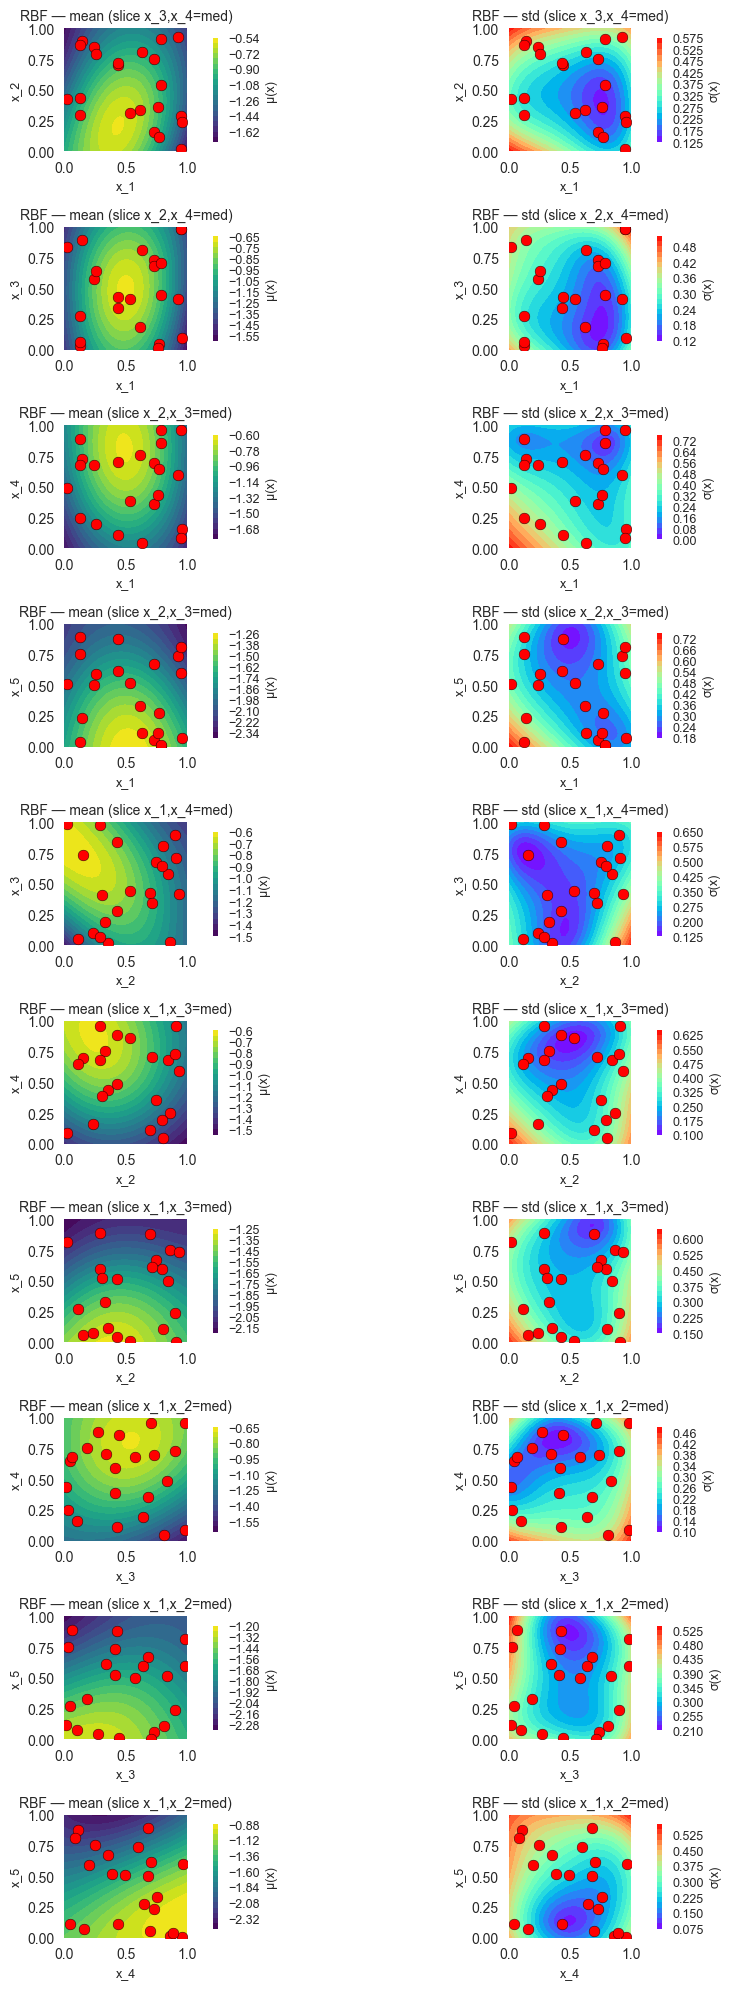

In [11]:
# Plot RBF GP on 2D slices for all 10 5D pairs (mean and std contours)
# 5D: fix two dims at median; vary (x_i, x_j) for pairs (0,1), (0,2), (0,3), (1,2), (1,3), (2,3)
n_slice = 50
ug = np.linspace(0, 1, n_slice)
Ug, Vg = np.meshgrid(ug, ug)
med = [np.median(X[:, k]) for k in range(5)]

pairs = [(0, 1, "x_1", "x_2"), (0, 2, "x_1", "x_3"), (0, 3, "x_1", "x_4"), (0, 4, "x_1", "x_5"), (1, 2, "x_2", "x_3"), (1, 3, "x_2", "x_4"), (1, 4, "x_2", "x_5"), (2, 3, "x_3", "x_4"), (2, 4, "x_3", "x_5"), (3, 4, "x_4", "x_5")]
slices_info = []
for ia, ib, la, lb in pairs:
    other = [k for k in range(5) if k not in (ia, ib)]
    slice_pts = np.zeros((Ug.size, 5))
    slice_pts[:, ia] = Ug.ravel()
    slice_pts[:, ib] = Vg.ravel()
    slice_pts[:, other[0]] = med[other[0]]
    slice_pts[:, other[1]] = med[other[1]]
    slice_label = f"x_{other[0]+1},x_{other[1]+1}=med"
    slices_info.append((slice_pts, Ug, Vg, ia, ib, la, lb, slice_label))

fig, axes = plt.subplots(10, 2, figsize=(10, 20))
for row, (slice_pts, Ag, Bg, ia, ib, la, lb, slice_label) in enumerate(slices_info):
    mu_slice, sigma_slice = gp_RBF.predict(slice_pts, return_std=True)
    mu_slice = mu_slice.reshape(Ug.shape)
    sigma_slice = sigma_slice.reshape(Ug.shape)
    ax_mu, ax_sig = axes[row, 0], axes[row, 1]
    cf1 = ax_mu.contourf(Ag, Bg, mu_slice, levels=20, cmap="viridis")
    add_colorbar(cf1, ax=ax_mu, label="μ(x)", font_size_axis=DEFAULT_FONT_SIZE_AXIS, shrink=0.85)
    ax_mu.scatter(X[:, ia], X[:, ib], c="red", s=60, edgecolors="k")
    style_axis(ax_mu, xlabel=la, ylabel=lb, title=f"RBF — mean (slice {slice_label})", font_size_axis=DEFAULT_FONT_SIZE_AXIS, font_size_titles=DEFAULT_FONT_SIZE_TITLES)
    ax_mu.set_aspect("equal")
    cf2 = ax_sig.contourf(Ag, Bg, sigma_slice, levels=20, cmap="rainbow")
    add_colorbar(cf2, ax=ax_sig, label="σ(x)", font_size_axis=DEFAULT_FONT_SIZE_AXIS, shrink=0.85)
    ax_sig.scatter(X[:, ia], X[:, ib], c="red", s=60, edgecolors="k")
    style_axis(ax_sig, xlabel=la, ylabel=lb, title=f"RBF — std (slice {slice_label})", font_size_axis=DEFAULT_FONT_SIZE_AXIS, font_size_titles=DEFAULT_FONT_SIZE_TITLES)
    ax_sig.set_aspect("equal")
plt.tight_layout()
if IF_EXPORT_PLOT:
    out_dir = PLOT_EXPORT_DIR
    assert_not_under_initial_data(out_dir, project_root=repo_root)
    out_dir.mkdir(parents=True, exist_ok=True)
    out_path = out_dir / f"function_6_gp_slices.{DEFAULT_EXPORT_FORMAT}"
    fig.savefig(out_path, dpi=DEFAULT_EXPORT_DPI, format=DEFAULT_EXPORT_FORMAT)
    print("Plot saved to", out_path)
if IF_SHOW_PLOT:
    plt.show()  


### 3.2 Acquisition functions

* Expected Improvement (EI)

* Upper Confidence Bound (UCB)

* Probability of Improvement (PI)


In [12]:
# ACQUISITION FUNCTION(s) — on 5D candidate_pts (mu_gp_RBF, sigma_gp_RBF are 1D arrays of length n_cand)

# --- EXPECTED IMPROVEMENT: EI = E[max(f(x) − f(x⁺), 0)] ---
y_best_EI = y.max()
EI_RBF = expected_improvement(mu_gp_RBF, sigma_gp_RBF, y_best_EI, xi=XI_EI_PI)
x_best_EI_RBF = candidate_pts[np.argmax(EI_RBF)]

# --- UPPER CONFIDENCE BOUND: UCB = μ(x) + κσ(x) ---
UCB_RBF = upper_confidence_bound(mu_gp_RBF, sigma_gp_RBF, kappa=KAPPA_UCB)
x_best_UCB_RBF = candidate_pts[np.argmax(UCB_RBF)]

# --- PROBABILITY OF IMPROVEMENT: PI = P(f(x) > f(x⁺)) ---
PI_RBF = probability_of_improvement(mu_gp_RBF, sigma_gp_RBF, y_best_EI, xi=XI_EI_PI)
x_best_PI_RBF = candidate_pts[np.argmax(PI_RBF)]

# --- THOMPSON SAMPLING ---
sample_thompson_RBF = thompson_sampling_sample(mu_gp_RBF, sigma_gp_RBF)
x_thomson_RBF = candidate_pts[np.argmax(sample_thompson_RBF)]

# --- ENTROPY SEARCH ---
ES_RBF = entropy_search(mu_gp_RBF, sigma_gp_RBF, y_best_EI, xi=XI_EI_PI)
x_entropy_RBF = candidate_pts[np.argmax(ES_RBF)]


In [13]:
# Baseline: suggest next x without GP — point with highest distance to nearest observation (explore far from data).
idx_high_dist = np.argmax(min_dist)
next_x_high_dist = np.asarray(candidate_pts[idx_high_dist]).ravel()
next_x_high_dist = np.clip(next_x_high_dist, 0.0, 0.999999)
next_x = next_x_high_dist
print("Suggested next x (high distance to obs):", next_x)


Suggested next x (high distance to obs): [0.08479202 0.71632339 0.07208434 0.07125673 0.01210848]


### 3.3 Acquisition function surfaces

2D slice heatmaps of EI over candidate pairs — shows *where* the acquisition function prefers to sample next.


### Pairwise distances between suggestions (small = agree)



In [14]:
# Compare suggested points (acquisition + high-distance baseline)
names = ['EI', 'UCB', 'PI', 'High dist']
pts = [np.asarray(x).ravel() for x in [x_best_EI_RBF, x_best_UCB_RBF, x_best_PI_RBF, next_x_high_dist]]
n_pts = len(pts)
dists = np.zeros((n_pts, n_pts))
for i in range(n_pts):
    for j in range(n_pts):
        dists[i, j] = np.linalg.norm(pts[i] - pts[j])
print("Pairwise L2 distances between acquisition suggestions:")
for i in range(n_pts):
    for j in range(i + 1, n_pts):
        print(f"  {names[i]} vs {names[j]}: {dists[i, j]:.4f}")
max_d = dists.max()
if max_d < 0.2:
    print("\n>>> Suggestions are similar (max pairwise distance < 0.2).")
else:
    print(f"\n>>> Suggestions differ (max pairwise distance = {max_d:.4f}); consider comparing strategies.")


Pairwise L2 distances between acquisition suggestions:
  EI vs UCB: 1.2591
  EI vs PI: 0.4339
  EI vs High dist: 1.3458
  UCB vs PI: 1.1324
  UCB vs High dist: 1.5566
  PI vs High dist: 1.0733

>>> Suggestions differ (max pairwise distance = 1.5566); consider comparing strategies.


## 4. Select next query

Pick the next input to submit. **EI RBF** (Expected Improvement with RBF kernel) is the default. **Strategy:** Start with EI and **max exploration** — in the coefficients cell (Section 3.1), `XI_EI_PI = 0.18` gives strong exploration (higher than the usual 0.01); you can try 0.2 for even more. See how it goes; later you can lower it for more exploitation. Alternative: `next_x_high_dist` (high distance to obs — explore unexplored regions).


In [15]:
# In this cell we select the next query to submit (5D: x_1, x_2, x_3, x_4, x_5).
# Change STRATEGY to switch acquisition function.
STRATEGY = "EI"    # "EI" | "UCB" | "PI" | "HighDist"

if STRATEGY == "EI":
    next_x = np.clip(np.asarray(x_best_EI_RBF).ravel(), 0.0, 0.999999)
elif STRATEGY == "UCB":
    next_x = np.clip(np.asarray(x_best_UCB_RBF).ravel(), 0.0, 0.999999)
elif STRATEGY == "PI":
    next_x = np.clip(np.asarray(x_best_PI_RBF).ravel(), 0.0, 0.999999)
elif STRATEGY == "HighDist":
    next_x = next_x_high_dist
else:
    raise ValueError(f"Unknown strategy: {STRATEGY}")

# Proximity check
MIN_DIST_THRESHOLD = 0.05
dist_to_obs = np.sqrt(((X - next_x) ** 2).sum(axis=1))
nearest_dist = dist_to_obs.min()
nearest_idx  = np.argmin(dist_to_obs)
if nearest_dist < MIN_DIST_THRESHOLD:
    print(f"WARNING: next_x is only {nearest_dist:.4f} from obs #{nearest_idx+1} — switching to high-dist fallback.")
    next_x = next_x_high_dist

print(f"[Strategy: {STRATEGY}]  next_x = {next_x}")


[Strategy: EI]  next_x = [0.23041666 0.00147382 0.72934479 0.9668455  0.22429348]


## 5. Illustrate the locations on the proposed query


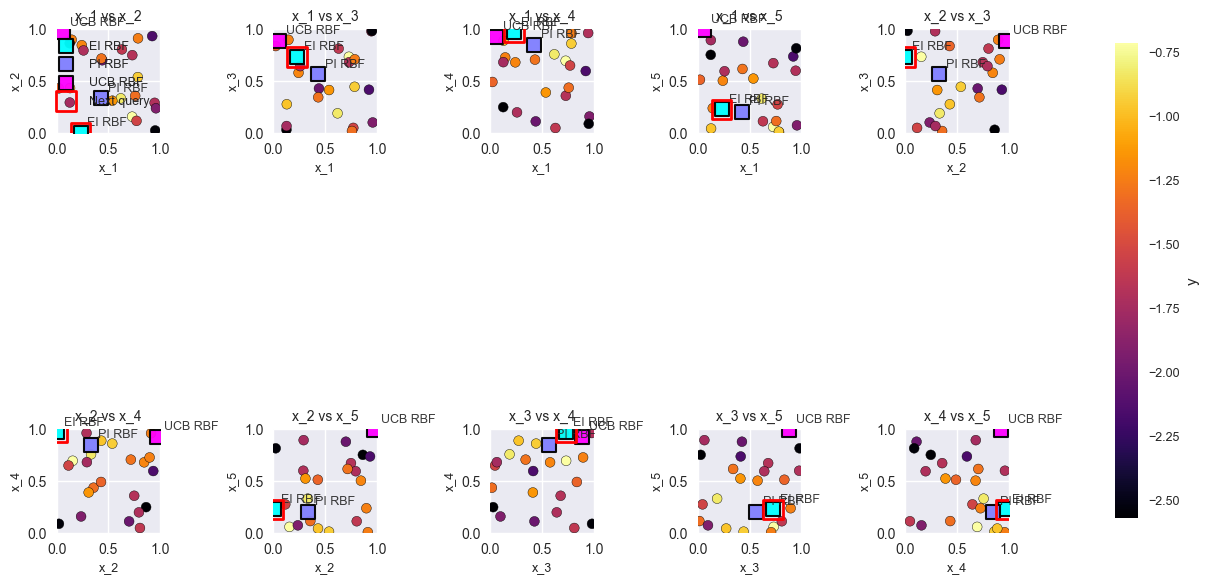

Plot saved to /Users/nikolaskarefyllidis/Desktop/60_ML-AI/10 main optimization/10 ICL BBO Challenge/black-box-optimization/data/results/function_6_acquisition_points_2d_pairs.png


In [16]:
# next_x is set in Section 4 (Select next query); fallback if that cell was skipped.
try:
    _ = next_x
except NameError:
    next_x = np.clip(np.asarray(x_best_EI_RBF).ravel(), 0.0, 0.999999)
    print("next_x fallback (EI RBF)")

# PLOT — acquisition next points, 5D: 2D pairwise view
X_best_combined = np.array([x_best_EI_RBF, x_best_PI_RBF, x_best_UCB_RBF])
labels_combined = ['EI RBF', 'PI RBF', 'UCB RBF']
colors_combined = plt.cm.cool(np.linspace(0, 1, len(X_best_combined)))

pairs = [(0,1,'x_1','x_2'),(0,2,'x_1','x_3'),(0,3,'x_1','x_4'),(0,4,'x_1','x_5'),(1,2,'x_2','x_3'),(1,3,'x_2','x_4'),(1,4,'x_2','x_5'),(2,3,'x_3','x_4'),(2,4,'x_3','x_5'),(3,4,'x_4','x_5')]
fig2, axes = plt.subplots(2, 5, figsize=(12, 8), constrained_layout=True)
axes = axes.ravel()
for ax, (i, j, li, lj) in zip(axes, pairs):
    sc = ax.scatter(X[:, i], X[:, j], c=y, s=50, cmap="inferno", edgecolors="k", zorder=2)
    for k, (pt, lbl) in enumerate(zip(X_best_combined, labels_combined)):
        ax.scatter(pt[i], pt[j], c=[colors_combined[k]], s=100, marker='s',
                   edgecolors="k", linewidths=1.5, alpha=0.95, label=lbl, zorder=3)
        ax.annotate(lbl, (pt[i], pt[j]), xytext=(5, 5), textcoords="offset points",
                    fontsize=DEFAULT_FONT_SIZE_AXIS, alpha=0.9, zorder=4)
    ax.scatter(next_x[i], next_x[j], facecolors='none', s=200, marker='s',
               edgecolors='red', linewidths=2, zorder=5,
               label='Next query' if ax is axes[0] else '')
    style_axis(ax, xlabel=li, ylabel=lj, title=f"{li} vs {lj}",
               font_size_axis=DEFAULT_FONT_SIZE_AXIS, font_size_titles=DEFAULT_FONT_SIZE_TITLES)
    ax.set_aspect("equal"); ax.set_xlim(0, 1); ax.set_ylim(0, 1)
axes[0].legend(loc="upper right", fontsize=DEFAULT_FONT_SIZE_AXIS)
sm = plt.cm.ScalarMappable(norm=plt.Normalize(y.min(), y.max()), cmap="inferno")
sm.set_array(y)
cbar = fig2.colorbar(sm, ax=axes, shrink=0.6, label="y")
cbar.ax.tick_params(labelsize=DEFAULT_FONT_SIZE_AXIS)
if IF_SHOW_PLOT:
    plt.show()
if IF_EXPORT_PLOT:
    out_dir = PLOT_EXPORT_DIR
    assert_not_under_initial_data(out_dir, project_root=repo_root)
    out_dir.mkdir(parents=True, exist_ok=True)
    out_path = out_dir / f"function_6_acquisition_points_2d_pairs.{DEFAULT_EXPORT_FORMAT}"
    fig2.savefig(out_path, dpi=DEFAULT_EXPORT_DPI, format=DEFAULT_EXPORT_FORMAT)
    print("Plot saved to", out_path)


In [17]:
if IF_EXPORT_QUERIES:
    # Portal format: each value 0.XXXXXX (exactly 6 decimals), in [0, 0.999999], hyphen-separated
    next_x_clip = np.clip(np.asarray(next_x, dtype=np.float64).ravel(), 0.0, 0.999999)
    portal_str = "-".join(f"{v:.6f}" for v in next_x_clip)
    out_dir = repo_root / "data" / "submissions" / "function_6"
    assert_not_under_initial_data(out_dir, project_root=repo_root)
    out_dir.mkdir(parents=True, exist_ok=True)
    np.save(out_dir / "next_input.npy", next_x_clip)
    (out_dir / "next_input_portal.txt").write_text(portal_str)
    print("Saved to", out_dir / "next_input.npy")
    print("Portal string (copy-paste to portal):", portal_str)
else:
    print("IF_EXPORT_QUERIES is False; next_input.npy not saved.")


Saved to /Users/nikolaskarefyllidis/Desktop/60_ML-AI/10 main optimization/10 ICL BBO Challenge/black-box-optimization/data/submissions/function_6/next_input.npy
Portal string (copy-paste to portal): 0.230417-0.001474-0.729345-0.966845-0.224293


## 6. Append new feedback (after portal returns)

After you submit and receive the new **(x, y)** from the portal for Function 4, paste the values below and run this cell. It appends to a local dataset under `data/problems/function_4/`. The next time you run the notebook from the top, section 1 will load from this local dataset (initial + all appended points).


In [18]:
if IF_APPEND_DATA:
    new_x = np.array([0.5, 0.5, 0.5, 0.5, 0.5])  # paste portal x values here
    new_y = np.array([0.0])     # paste portal y value here
    X = np.vstack([X, new_x.reshape(1, 5)])
    y = np.append(y.ravel(), new_y.ravel())
    csv_path.parent.mkdir(parents=True, exist_ok=True)
    assert_not_under_initial_data(csv_path.parent, project_root=repo_root)
    save_problem_data_csv(csv_path, X, y)
    print(f"Appended (x={new_x}, y={new_y[0]:.6f}) → {csv_path}")
else:
    print("IF_APPEND_DATA is False; nothing appended.")


IF_APPEND_DATA is False; nothing appended.
